In [219]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [220]:
#Checking wich GPU is beeing used

!nvidia-smi

Mon Nov 22 11:09:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   27C    P8    18W / 250W |  10073MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [221]:
#Load data
data_file = 'dialogue/Dataset/VoiceDetection/Output.npy'
labels = pd.read_csv("dialogue/Dataset/VoiceDetection/boolean_labels.csv")#path to csv
labels.drop(labels.columns[[0]], axis=1, inplace=True)
data = np.load(data_file, allow_pickle= True)
df_temp = pd.DataFrame()
df_data = pd.DataFrame()
#print(data)
df_data = pd.DataFrame(data)
#df_data['data'] = df_temp.values.tolist()
df_data = pd.concat([df_data, labels], axis = 1)
print(df_data.head())
np_labels = df_data['isSpeaking'].to_numpy()
np_data = data #df_data['data'].to_numpy()
#print(df_data)

           0          1          2          3          4          5  \
0 -79.622688 -68.915321 -65.059227 -62.764908 -65.256943 -65.382416   
1 -30.246622 -21.209921 -19.702814 -23.637451 -22.125731 -20.398275   
2  12.073426  15.358956  19.110779  15.739680  13.635072  16.379383   
3  41.255814  36.722012  36.718670  31.349783  31.124092  34.588085   
4 -52.424908 -42.299263 -33.751793 -36.985863 -40.802864 -44.164406   

           6          7          8          9  ...      1751      1752  \
0 -56.918060 -58.104752 -64.561028 -66.506653  ...  1.125655  4.336840   
1 -18.434788 -10.077910 -10.523500  -5.363644  ...  3.387088  3.399514   
2  16.585903  18.004755  14.891681  15.006295  ...  2.031411 -3.938447   
3  33.078079  35.942139  32.815281  30.097649  ...  5.018896  2.010961   
4 -46.463821 -37.635292 -39.767555 -51.597317  ...  8.349728  5.515449   

       1753      1754      1755      1756      1757      1758      1759  \
0  2.819887 -1.342875  2.755569  1.434361  0.691830  

In [222]:
#df_data.drop(['isSpeaking'],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(np_data, np_labels, test_size = 0.2, random_state = 23)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)
print(type(X_train))
#print(X_train)

<class 'numpy.ndarray'>


In [223]:
#print(pd.DataFrame(X_train))
X_train = torch.from_numpy(X_train).float()
X_train = X_train.unsqueeze_(-1)
X_train = X_train.transpose(2, 0)
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
X_test = X_test.unsqueeze_(-1)
X_test = X_test.transpose(2, 0)        #torch.tensor(X_test.values)
y_test = torch.from_numpy(y_test).float()
X_val = torch.from_numpy(X_val).float()
X_val = X_val.unsqueeze_(-1)
X_val = X_val.transpose(2, 0)
y_val = torch.from_numpy(y_val).float()
#print(X_val.shape, X_val)
print(X_train.shape, y_train.shape)
#print(test_X.shape)
#print(X_train)


torch.Size([1, 1760, 1472]) torch.Size([1472])


In [224]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 1280, kernel_size=1, stride = 1) #1 input channels, 100 output channels
        self.conv2 = nn.Conv1d(1280, 320, kernel_size=1, stride = 1) #100 input channels from previous Conv. layer, 75 out
        self.conv3 = nn.Conv1d(320, 160, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv4 = nn.Conv1d(160, 80, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv5 = nn.Conv1d(80, 60, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv5_drop = nn.Dropout2d() #dropout
        
        self.fc1 = nn.Linear(60, 50) #Fully-connected classifier layer
        self.fc2 = nn.Linear(50, 40) #Fully-connected classifier layer
        self.fc3 = nn.Linear(40, 30) #Fully-connected classifier layer
        self.fc4 = nn.Linear(30, 20) #Fully-connected classifier layer
        self.fc5 = nn.Linear(20,1) #Fully-connected classifier layer
    
    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 1))
        x = F.relu(F.max_pool1d(self.conv2(x), 1))
        x = F.relu(F.max_pool1d(self.conv3(x), 1))
        x = F.relu(F.max_pool1d(self.conv4(x), 1))
        x = F.relu(F.max_pool1d(self.conv5_drop(self.conv5(x)), 1))
        
        #point A
        x = x.transpose(1, 2)
        
        #point B
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc4(x)
        return torch.sigmoid(self.fc5(x))
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X_train.shape[1],kernel_size = 1)

In [225]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.001)

In [226]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
CNN = CNN.to(device)
criterion = criterion.to(device)

In [227]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [228]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_test', 'test_loss', 'train_loss'])
    
for epoch in range(1000):
        y_pred = CNN(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
        if epoch % 10 == 0:
        
            train_acc = calculate_accuracy(y_train, CNN.post_forward(y_pred))
        
            y_test_pred = CNN(X_test)

            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred, y_test)
        
            test_acc = calculate_accuracy(y_test, CNN.post_forward(y_test_pred))
        
            result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_test': round_tensor(test_acc), 'test_loss': round_tensor(test_loss), 'train_loss': round_tensor(train_loss)}

            Results = Results.append(result, ignore_index=True)

            print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
        optimizer.zero_grad()
    
        train_loss.backward()
    
        optimizer.step()


epoch 0
Train set - loss: 0.69, accuracy: 0.562
Test  set - loss: 0.692, accuracy: 0.535

epoch 10
Train set - loss: 0.429, accuracy: 0.728
Test  set - loss: 0.469, accuracy: 0.643

epoch 20
Train set - loss: 0.306, accuracy: 0.875
Test  set - loss: 0.356, accuracy: 0.798

epoch 30
Train set - loss: 0.223, accuracy: 0.918
Test  set - loss: 0.193, accuracy: 0.943

epoch 40
Train set - loss: 0.221, accuracy: 0.928
Test  set - loss: 0.222, accuracy: 0.93

epoch 50
Train set - loss: 0.26, accuracy: 0.915
Test  set - loss: 0.238, accuracy: 0.93

epoch 60
Train set - loss: 0.221, accuracy: 0.926
Test  set - loss: 0.211, accuracy: 0.943

epoch 70
Train set - loss: 0.231, accuracy: 0.929
Test  set - loss: 0.199, accuracy: 0.941

epoch 80
Train set - loss: 0.2, accuracy: 0.927
Test  set - loss: 0.205, accuracy: 0.937

epoch 90
Train set - loss: 0.197, accuracy: 0.93
Test  set - loss: 0.185, accuracy: 0.943

epoch 100
Train set - loss: 0.178, accuracy: 0.93
Test  set - loss: 0.213, accuracy: 0.9

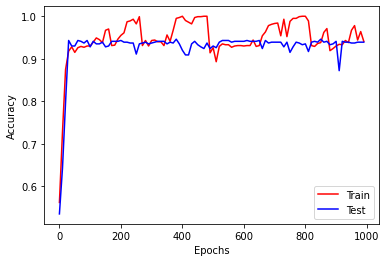

    Epoch  Acc_train  Acc_test  test_loss  train_loss
0     0.0      0.562     0.535      0.692       0.690
1    10.0      0.728     0.643      0.469       0.429
2    20.0      0.875     0.798      0.356       0.306
3    30.0      0.918     0.943      0.193       0.223
4    40.0      0.928     0.930      0.222       0.221
..    ...        ...       ...        ...         ...
95  950.0      0.967     0.937      0.228       0.105
96  960.0      0.978     0.937      0.279       0.082
97  970.0      0.944     0.939      0.215       0.143
98  980.0      0.964     0.939      0.253       0.087
99  990.0      0.941     0.939      0.180       0.126

[100 rows x 5 columns]


In [229]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_test,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

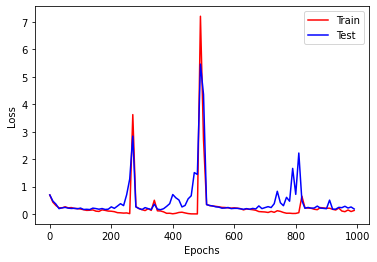

In [230]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.test_loss,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [231]:
classes = ['No Voice', 'Voice']
y_pred = CNN(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.99      0.89      0.94       241
       Voice       0.89      0.99      0.94       219

    accuracy                           0.94       460
   macro avg       0.94      0.94      0.94       460
weighted avg       0.94      0.94      0.94       460



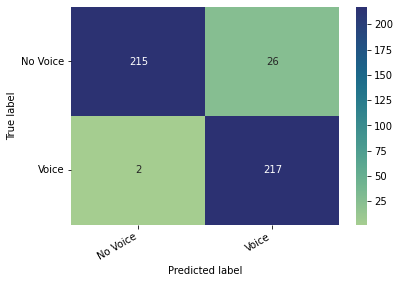

In [232]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
#hmap.color_palette("viridis", as_cmap=True)
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [233]:
y_pred = CNN(X_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       1.00      0.87      0.93       211
       Voice       0.85      1.00      0.92       157

    accuracy                           0.93       368
   macro avg       0.93      0.94      0.93       368
weighted avg       0.94      0.93      0.93       368



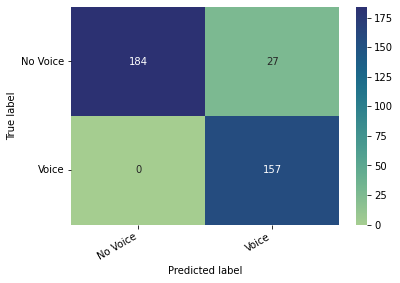

In [234]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [235]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
